In [1]:
from Organizer import Organizer
from search_agent import Research_Tool
import random
LENGTHY_SEARCH_PROMPT = """
                            Answer this question in this format:
                            {"status":"pending", "urls": list(str)}
                            YOU MUST PUT THE JSON ANSWER WITHIN TWO ```

                            Return a list of upto 5 urls from the provided ones that you would like to visit for more Context to answer the following question.
                            Question:
                            
                        """


Researcher = Organizer()
search = Research_Tool()

query = "All available colours of sunflowers"
urls = search.search(query, random.randint(10,15))
print(urls)
data = Researcher.get_filtered_urls(urls, LENGTHY_SEARCH_PROMPT, query)
print(data)
processed_data = await Researcher.process_url(data)
# final_report = await Researcher.multi_text_processor(query)


# final_report

[{'title': 'All Colors Sunflowers - SunflowerSelections.com', 'description': 'Gypsy Charmer explodes with vividcolorsin the garden. Three vibrantcolors, lemon, red, and yellow, are fused into pollenless flowers born on branching plants\xa0...', 'url': 'https://www.sunflowerselections.com/'}, {'title': '13 Crazy-Colorful Sunflowers to Grow in Your Garden', 'description': 'Sunflower colorsrange from cream to gold, yellow, orange, red, mahogany and chocolate brown. There are even pinksunflowers.', 'url': 'https://www.hgtv.com/outdoors/flowers-and-plants/flowers/13-crazy-colorful-sunflowers-pictures'}, {'title': 'Types of Sunflowers: A Guide | Petal Talk', 'description': 'There are several different varieties of bi-color sunflowers. Most feature a dark red center and gradually lighten to yellow at the tip.', 'url': 'https://www.1800flowers.com/articles/flower-facts/infographic-different-types-of-sunflowers'}, {'title': '160 Red & other colors of Sunflowers ideas', 'description': 'Red & oth

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin, quote_plus
from typing import Dict, Any, List
import re


def log_debug(message):
    print(f"DEBUG: {message}")

def extract_images(content):
    url_pattern = r'https?://www.[^\s]+'
    urls = re.findall(url_pattern, content)
    urls = [i for i in urls if i.startswith("https://") and (any(ext in i for ext in [".png", ".jpg", ".webp", ".jpeg"])) and "ssl" not in i]
    ans = []
    for i in urls[1:]:
        x= i.split(',')
        m = ["https://"+i.split("https://")[-1][:-1] for i in x if "https://" in i]
        ans.append(m)
    return ans


headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,/;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Referer': 'https://www.google.com/',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }

def _perform_web_search(query: str, no_of_results: int) -> List[Dict[str, Any]]:
    encoded_query = quote_plus(query)
    search_url = f"https://www.google.com/search?q={encoded_query}&tbm=isch&num={no_of_results * 2}"
    log_debug(f"Search URL: {search_url}")
    
    try:
        log_debug("Sending GET request to Google")
        response = requests.get(search_url, headers=headers, timeout=5)
        log_debug(f"Response status code: {response.status_code}")
        response.raise_for_status()
        
        log_debug("Parsing HTML with BeautifulSoup")
        soup = BeautifulSoup(response.text, 'html.parser')
        
        search_results = extract_images(str(soup))
        
        log_debug(f"Successfully retrieved {len(search_results)} search results for query: {query}")
        return search_results
    except requests.RequestException as e:
        log_debug(f"Error performing search: {str(e)}")
        return []

res = _perform_web_search("robovan", 5)
res

DEBUG: Search URL: https://www.google.com/search?q=robovan&tbm=isch&num=10
DEBUG: Sending GET request to Google


DEBUG: Response status code: 200
DEBUG: Parsing HTML with BeautifulSoup
DEBUG: Successfully retrieved 22 search results for query: robovan


[['https://www.edmunds.com/assets/m/cs/blt35b657fd08d26402/67089faa4c520056d471e2a2/Tesla_Robovan_010_500.jpg',
  'https://www.edmunds.com/car-news/tesla-robovan-autonomous-van-debut-first-look.html'],
 ['https://www.teslarati.com/wp-content/uploads/2022/07/tesla-robovan-concept-1-1024x455.jpg',
  'https://www.teslarati.com/tesla-elon-musk-tesla-robovan-configuration-teaser/'],
 ['https://www.motortrend.com/files/67089ec9d2074e0008e0ba59/teslarobovan8.jpg?w\\u003d768\\u0026width\\u003d768\\u0026q\\u003d75\\u0026format\\u003dwebp',
  'https://www.motortrend.com/news/tesla-robovan-first-look-review/'],
 ['https://www.notateslaapp.com/img/containers/article_images/robovan/robovan_81.jpeg/fb82f3f42effb5ca0b2fbf673f80af36/robovan_81.jpg'],
 ['https://www.teslarati.com/wp-content/uploads/2024/10/tesla-robovan-1-scaled.jpg',
  'https://www.teslarati.com/tesla-robovan-reveal-specs/'],
 ['https://www.teslarati.com/wp-content/uploads/2024/10/Robovan_70-scaled.jpg',
  'https://www.teslarati.com/e

In [10]:
import re

def extract_query(text: str) -> str:
    pattern = r"var m = {(.*?)var a = m;"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches[0] if matches else text


data = open("streamlit_components.py").read()

print("{"+extract_query(data).strip()[:-1])

{"CYlcFk": ["gws-wiz-serp", "", "sunflower", "", null, 1, 0, 0, 13, "en", null, "", "b4QSZ7_WN6KuiLMP_52l-AQ", 0, "en", null, null, null, 3, 5, -1, null, "89978449", null, 1, 1, 1800000, 1, 6, null, 1.15, 1, 1, 1, null, 1, 1, 0, null, null, null, null, 1, 1, null, "", 0, 1, null, null, null, 0, 0, null, null, null, null, "", 0, null, 1, -1, -1, null, 1, 0, 1, 1000, 1, ["gws-wiz-serp", "", ""], null, ["gws-wiz-modeless-local", "", ""], null, ["img", "gws-wiz-img", "i"], null, ["gws-wiz-modeless-products", "", "sh"], null, ["gws-wiz-modeless", "gws-wiz-perspectives", ""], null, ["gws-wiz-modeless-lodging", "", ""], null, ["gws-wiz-modeless-flights", "", ""], 1, null, 0, 1, null, null, null, ["gws-wiz-modeless-vss-products", "", ""], null, ["gws-wiz-modeless-vss-jobs", "", ""], null, ["gws-wiz-modeless-vss-local-travel", "", ""], 1, null, null, ["gws-wiz-modeless-video", "", "v"], null, null, null, ["gws-wiz-modeless-jobs", "", ""], null, ["gws-wiz-modeless-vss-flights", "", ""], null, ["

In [37]:

# x
# json_data = {"image": x[]}

['https://www.peachtreepetals.com/cdn/shop/articles/all_about_sunflowers.jpg?v\\u003d1631036676\\u0026width\\u003d1600',
 'https://www.peachtreepetals.com/blogs/peachtree-petals-flower-blog/all-about-sunflowers-10-beautiful-facts-about-sunflowers']

'<!doctype html><html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="en"><head><meta charset="UTF-8"><meta content="origin" name="referrer"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>robovan - Google Search</title><script nonce="dWolVzUewT0Hlu9Vi8SSGg">window._hst=Date.now();performance&&performance.mark&&performance.mark("SearchHeadStart");</script><script nonce="dWolVzUewT0Hlu9Vi8SSGg">(function(){var b=window.addEventListener;window.addEventListener=function(a,c,d){a!=="unload"&&b(a,c,d)};}).call(this);(function(){var _g={kEI:\'lKsSZ5-ZNrO60-kPy4axgAo\',kEXPI:\'31\',kBL:\'T4Sw\',kOPI:89978449};(function(){var a;((a=window.google)==null?0:a.stvsc)?google.kEI=_g.kEI:window.google=_g;}).call(this);})();(function(){google.sn=\'images\';google.kHL=\'en\';})();(function(){\nvar h=this||self;function l(){return window.google!==void 0&&window.google.kOPI!==void 0&&window.google.kOPI!==0?window.google.kOPI:null};var
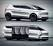
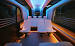
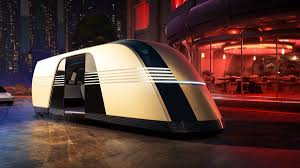
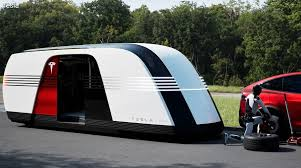
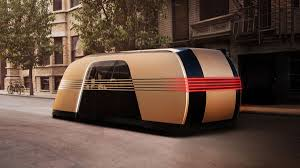
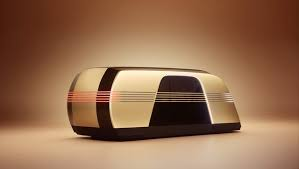
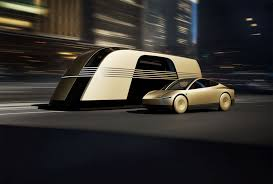
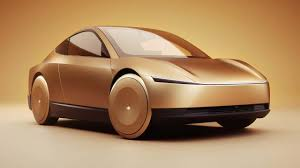
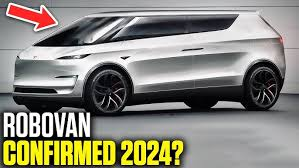
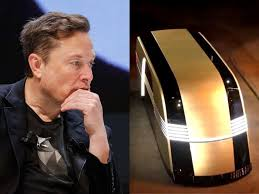
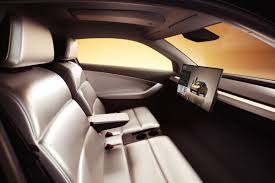
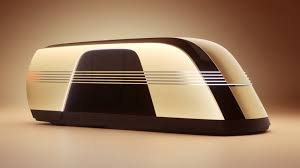
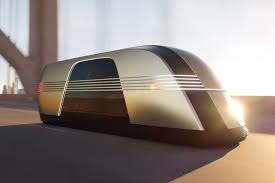
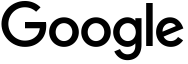

In [5]:
import requests

# cookies = {
#     'NID': '518=Yu7CJHUpj6JEbXaWxI007KX2bb9VempO9rvo0Z5Q-EkihGrkhY6watxPtCdYT1LuWMmJhijBXZEivN4hChKlLuWr3swS3eLgJakHvLPPS2HNk6p0pfLZWrZ33Dp5-m8BXm6OMp4uhRklQoOF-QehntfvVGrlIvtScXyB47EtSRpZRZDx_ZZEG9IusJcUMvo',
#     'AEC': 'AVYB7crp7SQO_cKJ6txbtE3VDXjq968GEeP5sb0Kc2UFkAr9Uu348edomJw',
# }



200


'<!doctype html><html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="en"><head><meta charset="UTF-8"><meta content="origin" name="referrer"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>robovan - Google Search</title><script nonce="1knhSrbjcbBqyLQkx29qXA">window._hst=Date.now();performance&&performance.mark&&performance.mark("SearchHeadStart");</script><script nonce="1knhSrbjcbBqyLQkx29qXA">(function(){var b=window.addEventListener;window.addEventListener=function(a,c,d){a!=="unload"&&b(a,c,d)};}).call(this);(function(){var _g={kEI:\'26wSZ7rbNJjS2roP18KPsAQ\',kEXPI:\'31\',kBL:\'T4Sw\',kOPI:89978449};(function(){var a;((a=window.google)==null?0:a.stvsc)?google.kEI=_g.kEI:window.google=_g;}).call(this);})();(function(){google.sn=\'images\';google.kHL=\'en\';})();(function(){\nvar h=this||self;function l(){return window.google!==void 0&&window.google.kOPI!==void 0&&window.google.kOPI!==0?window.google.kOPI:null};var
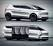
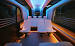
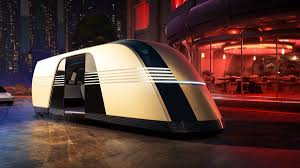
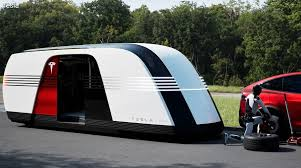
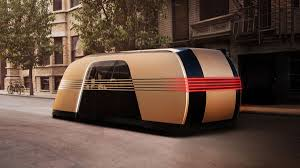
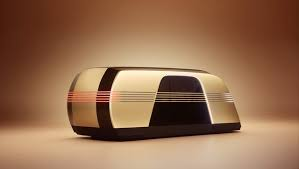
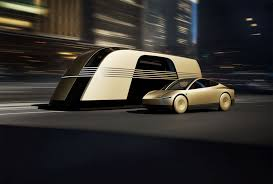
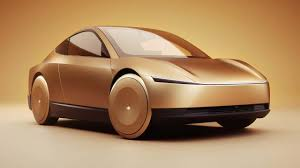
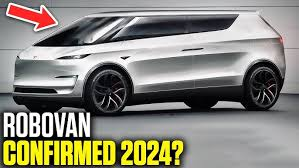
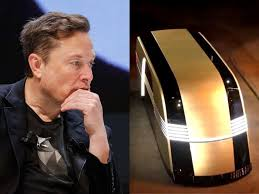
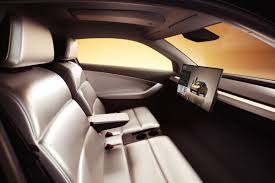
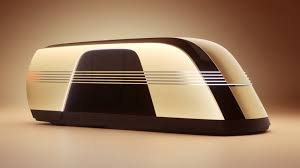
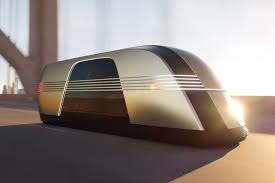
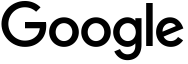